In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import zero_one_loss

%matplotlib inline

In [187]:
from utils.data_gen import compute_bayes_risk_binary, compute_bayes_risk_binary_label_shift,\
    generate_2d_example

from utils.data_gen import LDA_predictor
from utils.tests import Drop_tester,misclas_losses
from utils.concentrations import betting_ci_lower_limit,betting_ci_upper_limit

In [4]:
sns.set(style="whitegrid",
        font_scale=1.4,
        rc={
            "lines.linewidth": 2,
#             "axes.facecolor": ".9",
            'figure.figsize': (12, 6)
        })
sns.set_palette('Set2')
matplotlib.rcParams['text.usetex'] = True

In [89]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder


def confusion_matrix(y_true, y_pred, num_of_classes, cm_type):
    """
    Function that computes confusion matrix

    Parameters
    ----------
        y_true: array_like
            array of true class labels (without one-hot encoding)

        y_pred: array_like
            array of predicted class labels

        num_of_classes: int
            number of classes

        cm_type: 'soft'/'hard'
            type of confusion matrix to be computed 

    Returns
    -------
        confusion_matrix: array_like
            square matrix of shape num_of_classes with rows corresponding to predicted classes

    """

    num_of_preds = len(y_true)

    if cm_type == 'hard' and y_pred.ndim == 2:
        # convert predicted probabilities to class labels
        labels_pred = np.argmax(y_pred, axis=1)
    else:
        labels_pred = np.copy(y_pred)

    # fit encoder
    enc = OneHotEncoder()
    enc.fit(np.arange(num_of_classes).reshape(-1, 1))

    if cm_type == 'hard':
        # perform one-hot encoding of predicted labels and true labels
        y_true_transformed = enc.transform(y_true.reshape(-1, 1))
        y_pred_transformed = enc.transform(labels_pred.reshape(-1, 1))
        confusion_matrix = y_pred_transformed.T.dot(
            y_true_transformed).todense() / num_of_preds
    elif cm_type == 'soft':
        y_true_transformed = enc.transform(y_true.reshape(-1, 1)).todense()
        confusion_matrix = labels_pred.T.dot(y_true_transformed) / num_of_preds

    return np.asarray(confusion_matrix)


def imp_weights_bbse(model, X_source, y_source, X_target, n_classes, cm_type='hard', lmbd=0.0001):
    """
    Function that estimates importance weights via BBSE procedure

    Parameters
    ----------

    Returns
    -------
    """
    # get probabilistic predictions for the data on the source domain
    y_pred = model.predict_proba(X_source)

    # compute confusion matrix
    conf_mat = confusion_matrix(y_source, y_pred, n_classes, cm_type)

    # create hist of labels for the data from target domain
    if cm_type == 'hard':
        # update this
        y_pred_target = model.predict(X_target)
        n_preds = len(y_pred_target)
        mu = np.array([np.sum(y_pred_target == cur_class)
                       for cur_class in np.arange(n_classes)])/n_preds
    elif cm_type == 'soft':
        y_pred_target = model.predict_proba(X_target)
        mu = np.mean(y_pred_target, axis=0)

    # solve linear system for estimating imp weights
    # with small amount of regularization
    imp_weights = np.linalg.lstsq(
        conf_mat.T@conf_mat+lmbd*np.eye(n_classes), conf_mat.T @ mu, rcond=None)[0]

    # clip at zero if needed
    imp_weights = np.maximum(imp_weights, 0)

    return imp_weights

# Sims

In [246]:
eps_tol = 0.05

In [247]:
mu_1 = np.array([1,0])
mu_0 = np.array([-1,0])

In [248]:
X,y = generate_2d_example(0.25, mu_0, mu_1, 1000)

In [249]:
prob_source=0.3
prob_target=0.8

In [250]:
risk_target=compute_bayes_risk_binary_label_shift(prob_source, prob_target, mu_1,
                                      mu_0)[0][0]
risk_source=compute_bayes_risk_binary_label_shift(prob_source, prob_source, mu_1,
                                      mu_0)[0][0]

In [251]:
# estimate using labeled data
cand_sample_sizes=[100,200,300,400,500,600,700,800,900, 1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]

In [252]:
num_of_repeats = 100

In [253]:
clf = LDA_predictor()

clf.mean_class_0 = mu_0
clf.mean_class_1 = mu_1
clf.class_0_prior = 1 - prob_source
clf.class_1_prior = prob_source

In [254]:
lcb_risks_labeled = list()
ucb_risks = list()

In [255]:
for cur_ind, cur_sample_size in enumerate(cand_sample_sizes):
    lcb_risks_labeled+=[[]]
    
    X_source,y_source = generate_2d_example(prob_source, mu_0, mu_1, 1000)
    
    predictions_source = clf.predict(X_source).astype(int)
    cur_losses = misclas_losses(y_source,
                                    predictions_source).astype(int)
    
    ucb_risks+=[betting_ci_upper_limit(cur_losses, delta=0.025)]
    
    for cur_sim in range(num_of_repeats):
        X_target,y_target = generate_2d_example(prob_target, mu_0, mu_1, cur_sample_size)
        
        predictions = clf.predict(X_target).astype(int)
        cur_losses = misclas_losses(y_target,
                                    predictions).astype(int)
        
        lcb_risks_labeled[cur_ind]+=[betting_ci_lower_limit(cur_losses, delta=0.025)]

In [256]:
lcb_labeled_mean = np.mean(lcb_risks_labeled,axis=1)
lcb_labeled_std = np.std(lcb_risks_labeled,axis=1)

ucb_mean = np.mean(ucb_risks)
ucb_std = np.std(ucb_risks)

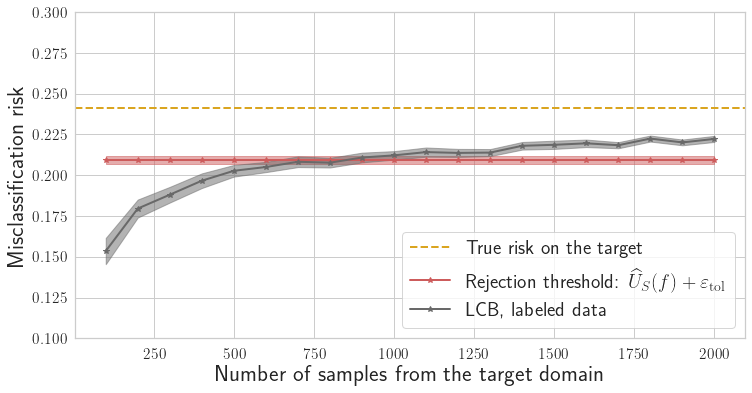

In [265]:
plt.axhline(risk_target,
            linestyle='dashed',
            c='goldenrod',
            label='True target risk')

# plt.axhline(risk_source + eps_tol,
#             linestyle='dashed',
#             c='indianred',
#             label='True risk on the source + ' + r'$\varepsilon_{\mathrm{tol}}$')

l1, = plt.plot(cand_sample_sizes,
               np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol,
               color='indianred',
               marker='*',
               label='Rejection threshold: '+r'$\widehat{U}_S(f)+\varepsilon_{\mathrm{tol}}$')

plt.fill_between(
    cand_sample_sizes,
    y1=np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol - 2 * ucb_std / np.sqrt(num_of_repeats),
    y2=np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol + 2 * ucb_std / np.sqrt(num_of_repeats),
    color='indianred',
    alpha=0.5)

l2, = plt.plot(cand_sample_sizes,
               lcb_labeled_mean,
               color='dimgray',
               marker='*',
               label='LCB, labeled data')

plt.fill_between(
    cand_sample_sizes,
    y1=lcb_labeled_mean - 2 * lcb_labeled_std / np.sqrt(num_of_repeats),
    y2=lcb_labeled_mean + 2 * lcb_labeled_std / np.sqrt(num_of_repeats),
    color='dimgray',
    alpha=0.5)

plt.ylabel('Misclassification risk', fontsize=23)
plt.xlabel('Number of samples from the target domain', fontsize=23)
plt.legend(loc=4, prop={'size': 20})
plt.ylim([0.1, 0.3])
plt.savefig('img/lcb_label_shift_labeled.pdf', bbox_inches='tight')

In [258]:
imp_weights = np.array([(1 - prob_target) / (1 - prob_source),
                        prob_target / prob_source])

In [259]:
lcb_risks_true_imp_weights = list()
lcb_risks_bbse_imp_weights = list()

In [260]:
clf.predict_both_classes = True

In [261]:
imp_weight_max=max(imp_weights)
imp_weight_min=min(imp_weights)

In [262]:
for cur_ind, cur_sample_size in enumerate(cand_sample_sizes):
    lcb_risks_true_imp_weights += [[]]
    lcb_risks_bbse_imp_weights += [[]]
    for cur_sim in range(num_of_repeats):
        X_source, y_source = generate_2d_example(prob_source, mu_0, mu_1,
                                                 cur_sample_size)

        #est_imp_weights

        X_weights_source, y_weights_source = generate_2d_example(
            prob_source, mu_0, mu_1, 200)
        X_weights_target, _ = generate_2d_example(prob_target, mu_0, mu_1, 200)

        est_weights = imp_weights_bbse(clf,
                                       X_weights_source,
                                       y_weights_source,
                                       X_weights_target,
                                       2,
                                       cm_type='soft',
                                       lmbd=0.00001)

        #truncate if needed
        est_weights = np.minimum(est_weights, imp_weight_max)

        predictions = clf.predict(X_source).astype(int)
        cur_losses = misclas_losses(y_source, predictions).astype(int)

        #rescale so that it losses are in [0,1]
        rescaled_weighted_losses = imp_weights[
            y_source] * cur_losses / imp_weight_max

        rescaled_est_weighted_losses = est_weights[
            y_source] * cur_losses / imp_weight_max

        lcb_risks_true_imp_weights[cur_ind] += [
            betting_ci_lower_limit(rescaled_weighted_losses, delta=0.05) *
            imp_weight_max
        ]
        lcb_risks_bbse_imp_weights[cur_ind] += [
            betting_ci_lower_limit(rescaled_est_weighted_losses, delta=0.05) *
            imp_weight_max
        ]

In [263]:
lcb_true_weights_mean = np.mean(lcb_risks_true_imp_weights,axis=1)
lcb_true_weights_std = np.std(lcb_risks_true_imp_weights,axis=1)

lcb_bbse_weights_mean = np.mean(lcb_risks_bbse_imp_weights,axis=1)
lcb_bbse_weights_std = np.std(lcb_risks_bbse_imp_weights,axis=1)

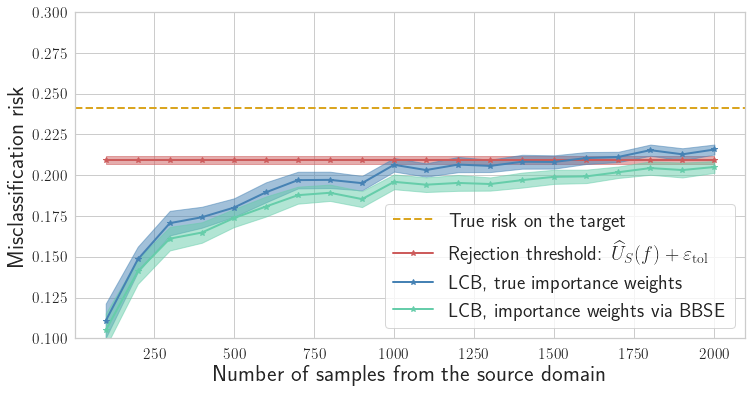

In [264]:
plt.axhline(risk_target,
            linestyle='dashed',
            c='goldenrod',
            label='True target risk')

l1, = plt.plot(cand_sample_sizes,
               np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol,
               color='indianred',
               marker='*',
               label='Rejection threshold: '+r'$\widehat{U}_S(f)+\varepsilon_{\mathrm{tol}}$')

plt.fill_between(
    cand_sample_sizes,
    y1=np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol - 2 * ucb_std / np.sqrt(num_of_repeats),
    y2=np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol + 2 * ucb_std / np.sqrt(num_of_repeats),
    color='indianred',
    alpha=0.5)

l2, = plt.plot(cand_sample_sizes,
               lcb_true_weights_mean,
               color='steelblue',
               marker='*',
               label='LCB, true importance weights')

plt.fill_between(cand_sample_sizes,
                 y1=lcb_true_weights_mean -
                 2 * lcb_true_weights_std / np.sqrt(num_of_repeats),
                 y2=lcb_true_weights_mean +
                 2 * lcb_true_weights_std / np.sqrt(num_of_repeats),
                 color='steelblue',
                 alpha=0.5)

l2, = plt.plot(cand_sample_sizes,
               lcb_bbse_weights_mean,
               color='mediumaquamarine',
               marker='*',
               label='LCB, importance weights via BBSE')

plt.fill_between(cand_sample_sizes,
                 y1=lcb_bbse_weights_mean -
                 2 * lcb_bbse_weights_std / np.sqrt(num_of_repeats),
                 y2=lcb_bbse_weights_mean +
                 2 * lcb_bbse_weights_std / np.sqrt(num_of_repeats),
                 color='mediumaquamarine',
                 alpha=0.5)

plt.ylabel('Misclassification risk', fontsize=23)
plt.xlabel('Number of samples from the source domain', fontsize=23)
plt.legend(loc=4, prop={'size': 20})
plt.ylim([0.1, 0.3])
plt.savefig('img/lcb_label_shift_unlabeled.pdf', bbox_inches='tight')

# Null case

In [266]:
prob_source=0.3
prob_target=0.3

In [268]:
imp_weights = np.array([(1 - prob_target) / (1 - prob_source),
                        prob_target / prob_source])

In [269]:
imp_weight_max=max(imp_weights)
imp_weight_min=min(imp_weights)

In [270]:
imp_weights

array([1., 1.])

In [267]:
null_lcb_risks_true_imp_weights = list()
null_lcb_risks_bbse_imp_weights = list()

In [271]:
for cur_ind, cur_sample_size in enumerate(cand_sample_sizes):
    null_lcb_risks_true_imp_weights += [[]]
    null_lcb_risks_bbse_imp_weights += [[]]
    for cur_sim in range(num_of_repeats):
        X_source, y_source = generate_2d_example(prob_source, mu_0, mu_1,
                                                 cur_sample_size)

        #est_imp_weights

        X_weights_source, y_weights_source = generate_2d_example(
            prob_source, mu_0, mu_1, 200)
        X_weights_target, _ = generate_2d_example(prob_target, mu_0, mu_1, 200)

        est_weights = imp_weights_bbse(clf,
                                       X_weights_source,
                                       y_weights_source,
                                       X_weights_target,
                                       2,
                                       cm_type='soft',
                                       lmbd=0.00001)

        #truncate if needed
        est_weights = np.minimum(est_weights, imp_weight_max)

        predictions = clf.predict(X_source).astype(int)
        cur_losses = misclas_losses(y_source, predictions).astype(int)

        #rescale so that it losses are in [0,1]
        rescaled_weighted_losses = imp_weights[
            y_source] * cur_losses / imp_weight_max

        rescaled_est_weighted_losses = est_weights[
            y_source] * cur_losses / imp_weight_max

        null_lcb_risks_true_imp_weights[cur_ind] += [
            betting_ci_lower_limit(rescaled_weighted_losses, delta=0.05) *
            imp_weight_max
        ]
        null_lcb_risks_bbse_imp_weights[cur_ind] += [
            betting_ci_lower_limit(rescaled_est_weighted_losses, delta=0.05) *
            imp_weight_max
        ]

In [272]:
risk_target=compute_bayes_risk_binary_label_shift(prob_source, prob_target, mu_1,
                                      mu_0)[0][0]
risk_source=compute_bayes_risk_binary_label_shift(prob_source, prob_source, mu_1,
                                      mu_0)[0][0]

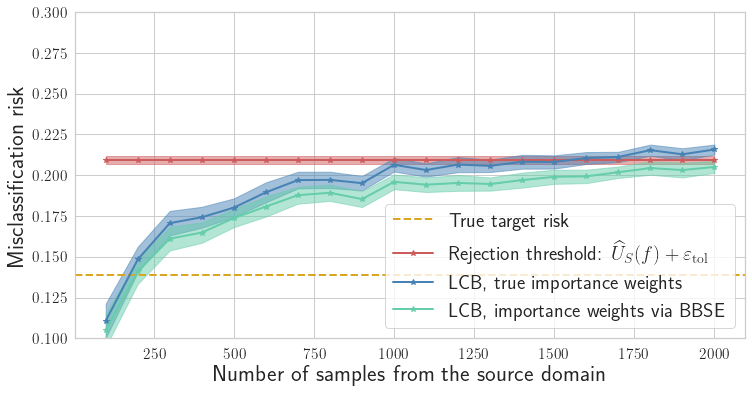

In [273]:
plt.axhline(risk_target,
            linestyle='dashed',
            c='goldenrod',
            label='True target risk')

l1, = plt.plot(cand_sample_sizes,
               np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol,
               color='indianred',
               marker='*',
               label='Rejection threshold: '+r'$\widehat{U}_S(f)+\varepsilon_{\mathrm{tol}}$')

plt.fill_between(
    cand_sample_sizes,
    y1=np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol - 2 * ucb_std / np.sqrt(num_of_repeats),
    y2=np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol + 2 * ucb_std / np.sqrt(num_of_repeats),
    color='indianred',
    alpha=0.5)

l2, = plt.plot(cand_sample_sizes,
               lcb_true_weights_mean,
               color='steelblue',
               marker='*',
               label='LCB, true importance weights')

plt.fill_between(cand_sample_sizes,
                 y1=lcb_true_weights_mean -
                 2 * lcb_true_weights_std / np.sqrt(num_of_repeats),
                 y2=lcb_true_weights_mean +
                 2 * lcb_true_weights_std / np.sqrt(num_of_repeats),
                 color='steelblue',
                 alpha=0.5)

l2, = plt.plot(cand_sample_sizes,
               lcb_bbse_weights_mean,
               color='mediumaquamarine',
               marker='*',
               label='LCB, importance weights via BBSE')

plt.fill_between(cand_sample_sizes,
                 y1=lcb_bbse_weights_mean -
                 2 * lcb_bbse_weights_std / np.sqrt(num_of_repeats),
                 y2=lcb_bbse_weights_mean +
                 2 * lcb_bbse_weights_std / np.sqrt(num_of_repeats),
                 color='mediumaquamarine',
                 alpha=0.5)

plt.ylabel('Misclassification risk', fontsize=23)
plt.xlabel('Number of samples from the source domain', fontsize=23)
plt.legend(loc=4, prop={'size': 20})
plt.ylim([0.1, 0.3])
plt.savefig('img/null_lcb_label_shift_unlabeled.pdf', bbox_inches='tight')

# increasing sample size on the target

In [305]:
# estimate using labeled data
cand_sample_sizes=[100,200,300,400,500,600,700,800,900, 1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]

In [306]:
prob_source=0.3
prob_target=0.8

In [307]:
imp_weights = np.array([(1 - prob_target) / (1 - prob_source),
                        prob_target / prob_source])

In [308]:
imp_weight_max=max(imp_weights)
imp_weight_min=min(imp_weights)

In [309]:
lcb_risks_250 = list()
lcb_risks_500 = list()
lcb_risks_1000 = list()
ucb_risks = list()

In [310]:
for cur_ind, cur_sample_size in enumerate(cand_sample_sizes):
    lcb_risks_250 += [[]]
    lcb_risks_500 += [[]]
    lcb_risks_1000 += [[]]
    
    X_source,y_source = generate_2d_example(prob_source, mu_0, mu_1, 500)
    
    predictions_source = clf.predict(X_source).astype(int)
    cur_losses = misclas_losses(y_source,
                                    predictions_source).astype(int)
    
    ucb_risks+=[betting_ci_upper_limit(cur_losses, delta=0.025)]
    
    
    for cur_sim in range(num_of_repeats):
        #250 points from source
        X_source, y_source = generate_2d_example(prob_source, mu_0, mu_1, 250)

        #est_imp_weights

        X_weights_source, y_weights_source = generate_2d_example(
            prob_source, mu_0, mu_1, 500)
        X_weights_target, _ = generate_2d_example(prob_target, mu_0, mu_1,
                                                  cur_sample_size)

        est_weights = imp_weights_bbse(clf,
                                       X_weights_source,
                                       y_weights_source,
                                       X_weights_target,
                                       2,
                                       cm_type='soft',
                                       lmbd=0.00001)

        #truncate if needed
        est_weights = np.minimum(est_weights, imp_weight_max)

        predictions = clf.predict(X_source).astype(int)
        cur_losses = misclas_losses(y_source, predictions).astype(int)

        rescaled_est_weighted_losses = est_weights[
            y_source] * cur_losses / imp_weight_max

        lcb_risks_250[cur_ind] += [
            betting_ci_lower_limit(rescaled_est_weighted_losses, delta=0.025) *
            imp_weight_max
        ]
        
        #500 points from source
        X_source, y_source = generate_2d_example(prob_source, mu_0, mu_1, 500)

        #est_imp_weights

        X_weights_source, y_weights_source = generate_2d_example(
            prob_source, mu_0, mu_1, 500)
        X_weights_target, _ = generate_2d_example(prob_target, mu_0, mu_1,
                                                  cur_sample_size)

        est_weights = imp_weights_bbse(clf,
                                       X_weights_source,
                                       y_weights_source,
                                       X_weights_target,
                                       2,
                                       cm_type='soft',
                                       lmbd=0.00001)

        #truncate if needed
        est_weights = np.minimum(est_weights, imp_weight_max)

        predictions = clf.predict(X_source).astype(int)
        cur_losses = misclas_losses(y_source, predictions).astype(int)

        rescaled_est_weighted_losses = est_weights[
            y_source] * cur_losses / imp_weight_max

        lcb_risks_500[cur_ind] += [
            betting_ci_lower_limit(rescaled_est_weighted_losses, delta=0.025) *
            imp_weight_max
        ]
        
        #1000 points from source
        X_source, y_source = generate_2d_example(prob_source, mu_0, mu_1, 1000)

        #est_imp_weights

        X_weights_source, y_weights_source = generate_2d_example(
            prob_source, mu_0, mu_1, 500)
        X_weights_target, _ = generate_2d_example(prob_target, mu_0, mu_1,
                                                  cur_sample_size)

        est_weights = imp_weights_bbse(clf,
                                       X_weights_source,
                                       y_weights_source,
                                       X_weights_target,
                                       2,
                                       cm_type='soft',
                                       lmbd=0.00001)

        #truncate if needed
        est_weights = np.minimum(est_weights, imp_weight_max)

        predictions = clf.predict(X_source).astype(int)
        cur_losses = misclas_losses(y_source, predictions).astype(int)

        rescaled_est_weighted_losses = est_weights[
            y_source] * cur_losses / imp_weight_max

        lcb_risks_1000[cur_ind] += [
            betting_ci_lower_limit(rescaled_est_weighted_losses, delta=0.025) *
            imp_weight_max
        ]

In [311]:
risk_target=compute_bayes_risk_binary_label_shift(prob_source, prob_target, mu_1,
                                      mu_0)[0][0]
risk_source=compute_bayes_risk_binary_label_shift(prob_source, prob_source, mu_1,
                                      mu_0)[0][0]

In [312]:
lcb_250_mean = np.mean(lcb_risks_250,axis=1)
lcb_250_std = np.std(lcb_risks_250,axis=1)

lcb_500_mean = np.mean(lcb_risks_500,axis=1)
lcb_500_std = np.std(lcb_risks_500,axis=1)

lcb_1000_mean = np.mean(lcb_risks_1000,axis=1)
lcb_1000_std = np.std(lcb_risks_1000,axis=1)

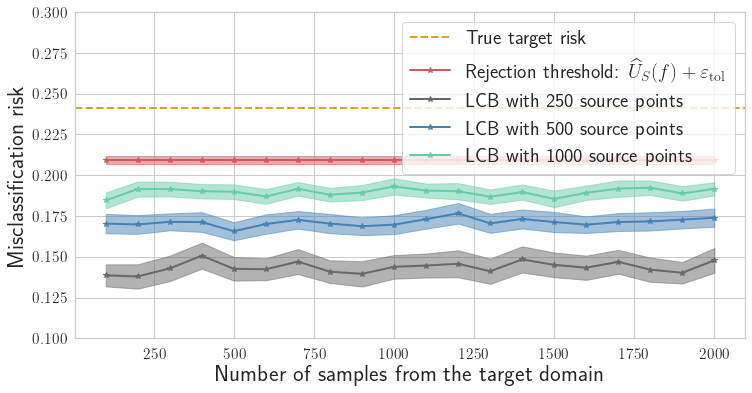

In [315]:
plt.axhline(risk_target,
            linestyle='dashed',
            c='goldenrod',
            label='True target risk')

l1, = plt.plot(cand_sample_sizes,
               np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol,
               color='indianred',
               marker='*',
               label='Rejection threshold: '+r'$\widehat{U}_S(f)+\varepsilon_{\mathrm{tol}}$')

plt.fill_between(
    cand_sample_sizes,
    y1=np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol - 2 * ucb_std / np.sqrt(num_of_repeats),
    y2=np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol + 2 * ucb_std / np.sqrt(num_of_repeats),
    color='indianred',
    alpha=0.5)

l2, = plt.plot(cand_sample_sizes,
               lcb_250_mean,
               color='dimgray',
               marker='*',
               label='LCB with 250 source points')

plt.fill_between(cand_sample_sizes,
                 y1=lcb_250_mean -
                 2 * lcb_250_std / np.sqrt(num_of_repeats),
                 y2=lcb_250_mean +
                 2 * lcb_250_std / np.sqrt(num_of_repeats),
                 color='dimgray',
                 alpha=0.5)


l3, = plt.plot(cand_sample_sizes,
               lcb_500_mean,
               color='steelblue',
               marker='*',
               label='LCB with 500 source points')

plt.fill_between(cand_sample_sizes,
                 y1=lcb_500_mean -
                 2 * lcb_500_std / np.sqrt(num_of_repeats),
                 y2=lcb_500_mean +
                 2 * lcb_500_std / np.sqrt(num_of_repeats),
                 color='steelblue',
                 alpha=0.5)

l4, = plt.plot(cand_sample_sizes,
               lcb_1000_mean,
               color='mediumaquamarine',
               marker='*',
               label='LCB with 1000 source points')

plt.fill_between(cand_sample_sizes,
                 y1=lcb_1000_mean -
                 2 * lcb_1000_std / np.sqrt(num_of_repeats),
                 y2=lcb_1000_mean +
                 2 * lcb_1000_std / np.sqrt(num_of_repeats),
                 color='mediumaquamarine',
                 alpha=0.5)

plt.ylabel('Misclassification risk', fontsize=23)
plt.xlabel('Number of samples from the target domain', fontsize=23)
plt.legend(loc=1, prop={'size': 20})
plt.ylim([0.1, 0.3])
plt.savefig('img/lcb_label_shift_unlabeled_target.pdf', bbox_inches='tight')

In [293]:
risk_target

0.11206652245619626

In [294]:
risk_source

0.13874852997086576

In [ ]:
plt.axhline(risk_target,
            linestyle='dashed',
            c='goldenrod',
            label='True target risk')

l1, = plt.plot(cand_sample_sizes,
               np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol,
               color='indianred',
               marker='*',
               label='Rejection threshold: '+r'$\widehat{U}_S(f)+\varepsilon_{\mathrm{tol}}$')

plt.fill_between(
    cand_sample_sizes,
    y1=np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol - 2 * ucb_std / np.sqrt(num_of_repeats),
    y2=np.repeat(ucb_mean,len(cand_sample_sizes))+eps_tol + 2 * ucb_std / np.sqrt(num_of_repeats),
    color='indianred',
    alpha=0.5)

l2, = plt.plot(cand_sample_sizes,
               lcb_250_mean,
               color='dimgray',
               marker='*',
               label='LCB with 250 source points')

plt.fill_between(cand_sample_sizes,
                 y1=lcb_250_mean -
                 2 * lcb_250_std / np.sqrt(num_of_repeats),
                 y2=lcb_250_mean +
                 2 * lcb_250_std / np.sqrt(num_of_repeats),
                 color='dimgray',
                 alpha=0.5)


l3, = plt.plot(cand_sample_sizes,
               lcb_500_mean,
               color='steelblue',
               marker='*',
               label='LCB with 500 source points')

plt.fill_between(cand_sample_sizes,
                 y1=lcb_500_mean -
                 2 * lcb_500_std / np.sqrt(num_of_repeats),
                 y2=lcb_500_mean +
                 2 * lcb_500_std / np.sqrt(num_of_repeats),
                 color='steelblue',
                 alpha=0.5)

l4, = plt.plot(cand_sample_sizes,
               lcb_1000_mean,
               color='mediumaquamarine',
               marker='*',
               label='LCB with 1000 source points')

plt.fill_between(cand_sample_sizes,
                 y1=lcb_1000_mean -
                 2 * lcb_1000_std / np.sqrt(num_of_repeats),
                 y2=lcb_1000_mean +
                 2 * lcb_1000_std / np.sqrt(num_of_repeats),
                 color='mediumaquamarine',
                 alpha=0.5)

plt.ylabel('Misclassification risk', fontsize=23)
plt.xlabel('Number of samples from the target domain', fontsize=23)
plt.legend(loc=4, prop={'size': 20})
plt.ylim([0.1, 0.3])
plt.savefig('img/lcb_label_shift_unlabeled_target.pdf', bbox_inches='tight')